<a href="https://colab.research.google.com/github/abdolrahman3791/MyNeuralNetworkProjects/blob/main/tumor_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import files
#upload kaggle.json
_ = files.upload()

Saving kaggle.json to kaggle.json


In [3]:
!mkdir /root/.config/kaggle
!cp kaggle.json /root/.config/kaggle/

mkdir: cannot create directory ‘/root/.config/kaggle’: File exists


In [8]:
import kaggle
!kaggle datasets download -d ahmedsorour1/mri-for-brain-tumor-with-bounding-boxes
!unzip -qq mri-for-brain-tumor-with-bounding-boxes

Dataset URL: https://www.kaggle.com/datasets/ahmedsorour1/mri-for-brain-tumor-with-bounding-boxes
License(s): CC0-1.0
mri-for-brain-tumor-with-bounding-boxes.zip: Skipping, found more recently modified local copy (use --force to force download)


In [9]:
import os
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, BatchNormalization, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D
import numpy as np
import cv2
import shutil
import matplotlib.pyplot as plt

In [10]:
class_names = ["Glioma", "Meningioma", "No Tumor", "Pituitary"]
def data_names(branch='Train'):
    image_files = {}
    for i in range(len(class_names)):
        image_files[class_names[i]] = ([file for file in os.listdir(f"/content/{branch}/{class_names[i]}/images") if file.lower().endswith(('.jpg'))])

    return image_files

def read_data(image_size, files, branch='Train'):
    images = []
    labels = []
    for i in class_names:
        for img_name in files[i]:
            image_path = f"/content/{branch}/"+i+'/images/'+img_name
            label_path = image_path.replace('jpg', 'txt').replace('images', 'labels')
            lbl = ''
            if os.path.exists(label_path):
              lbl = open(label_path).readline()
            if len(lbl) > 0:
                images.append(cv2.resize(cv2.imread(image_path), (image_size, image_size)))
                labels.append(np.array(lbl.split()).astype("float32"))

    return images, labels

def label_split(labels):
    bboxs = labels[:, 1:]#*image_size.astype('uint16')
    tumor_classes = labels[:, :1]

    return bboxs, tumor_classes

def show(img, tumor_class, pred_bbox, real_bbox=np.array([0, 0, 0, 0])):
    img = img.astype('uint16')
    pred_bbox = pred_bbox.astype('uint16')
    real_bbox = real_bbox.astype('uint16')
    print(tumor_class)
    img = cv2.rectangle(img, (pred_bbox[0], pred_bbox[1]), (pred_bbox[2], pred_bbox[3]), (255, 0, 0), 1)
    img = cv2.rectangle(img, (real_bbox[0], real_bbox[1]), (real_bbox[2], real_bbox[3]), (0, 255, 0), 1)
    plt.imshow(img)

In [11]:
train_image_files = data_names('Train')
test_image_files = data_names('Val')
len(train_image_files), len(test_image_files)

(4, 4)

In [12]:
image_size = 140
train_images, train_labels = read_data(image_size, train_image_files, 'Train')
train_images = np.array(train_images)
train_labels = np.array(train_labels)

test_images, test_labels = read_data(image_size, test_image_files, 'Val')
test_images = np.array(test_images)
test_labels = np.array(test_labels)

train_images = train_images.astype("float32") / 255
test_images = test_images.astype("float32") / 255

In [13]:
train_bboxs, train_tumor_classes = label_split(train_labels)
test_bboxs, test_tumor_classes = label_split(test_labels)

In [14]:
xu = train_bboxs[:, 0]-train_bboxs[:, 2]/2
yu = train_bboxs[:, 1]-train_bboxs[:, 3]/2
xd = train_bboxs[:, 0]+train_bboxs[:, 2]/2
yd = train_bboxs[:, 1]+train_bboxs[:, 3]/2
train_bboxs[:, 0] = xu
train_bboxs[:, 1] = yu
train_bboxs[:, 2] = xd
train_bboxs[:, 3] = yd

xu = test_bboxs[:, 0]-test_bboxs[:, 2]/2
yu = test_bboxs[:, 1]-test_bboxs[:, 3]/2
xd = test_bboxs[:, 0]+test_bboxs[:, 2]/2
yd = test_bboxs[:, 1]+test_bboxs[:, 3]/2
test_bboxs[:, 0] = xu
test_bboxs[:, 1] = yu
test_bboxs[:, 2] = xd
test_bboxs[:, 3] = yd

Glioma


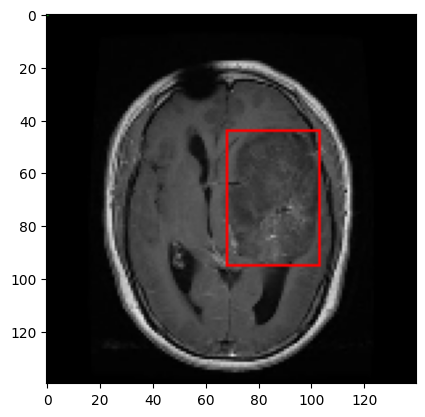

In [15]:
i = 0
show(train_images[i]*255, class_names[train_tumor_classes[i][0].astype('uint16')], train_bboxs[i]*image_size)

In [18]:
def res(inp, filters=32):
  x = Conv2D(filters, (3, 3), activation='leaky_relu', padding='same')(inp)
  x = BatchNormalization()(x)
  x = Conv2D(filters, (3, 3), activation='leaky_relu', padding='same')(x)
  x = BatchNormalization()(x)
  if inp.shape[-1] != filters:
    inp = Conv2D(filters, (1, 1), activation='leaky_relu', padding='same')(inp)
    inp = BatchNormalization()(inp)
  x = keras.layers.Add()([inp, x])
  return x

min_filters = 64
inputs = keras.Input(shape=(image_size, image_size, 3))

x = Conv2D(32, (3, 3), activation='leaky_relu', padding='same')(inputs)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='leaky_relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='leaky_relu', padding='same')(x)
x = BatchNormalization()(x)

for i in range(4):
  x = MaxPooling2D((2, 2))(x)
  x = res(x, pow(2, i)*min_filters)
  x = res(x, pow(2, i)*min_filters)
  x = res(x, pow(2, i)*min_filters)

x = GlobalAveragePooling2D()(x)
outputs = Flatten()(x)

myRes = keras.Model(inputs=inputs, outputs=outputs)

In [19]:
inputs = keras.Input(shape=(image_size, image_size, 3))

x = myRes(inputs)

class_head = Dense(256, activation='leaky_relu')(x)
class_head = Dropout(0.2)(class_head)
class_head = BatchNormalization()(class_head)
class_head = Dense(256, activation='leaky_relu')(class_head)
class_head = Dropout(0.2)(class_head)
class_head = BatchNormalization()(class_head)
class_head = Dense(4, activation='softmax', name='class')(class_head)

bbox_head = Dense(256, activation='leaky_relu')(x)
bbox_head = Dropout(0.2)(bbox_head)
bbox_head = BatchNormalization()(bbox_head)
bbox_head = Dense(256, activation='leaky_relu')(bbox_head)
bbox_head = Dropout(0.2)(bbox_head)
bbox_head = BatchNormalization()(bbox_head)
bbox_head = Dense(4, name='bbox')(bbox_head)

model = keras.Model(inputs=inputs, outputs=[class_head, bbox_head])

In [20]:
losses = {'class':'sparse_categorical_crossentropy',
          'bbox':'mse'}
metrics = {'class':'accuracy',
           'bbox':'mae'}
model.compile(loss=losses, optimizer='rmsprop', metrics=metrics)

train_targets = {'class':train_tumor_classes,
                 'bbox':train_bboxs}
test_targets = {'class':test_tumor_classes,
                'bbox':test_bboxs}
early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=32, restore_best_weights=True)
reduce = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=16, factor=0.1)
history = model.fit(train_images, train_targets, epochs=100, batch_size=128, shuffle=True, validation_data=(test_images, test_targets), callbacks=[reduce, early])

Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - bbox_loss: 1.6460 - bbox_mae: 0.8821 - class_accuracy: 0.4944 - class_loss: 1.4527 - loss: 3.0997 - val_bbox_loss: 2.9589 - val_bbox_mae: 1.4450 - val_class_accuracy: 0.1081 - val_class_loss: 5.6930 - val_loss: 8.6783 - learning_rate: 0.0010
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 34s 893ms/step - bbox_loss: 0.5474 - bbox_mae: 0.4866 - class_accuracy: 0.6746 - class_loss: 0.8699 - loss: 1.4172 - val_bbox_loss: 497.7141 - val_bbox_mae: 15.5868 - val_class_accuracy: 0.1925 - val_class_loss: 420.4490 - val_loss: 917.9647 - learning_rate: 0.0010
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 33s 866ms/step - bbox_loss: 0.4134 - bbox_mae: 0.4085 - class_accuracy: 0.7346 - class_loss: 0.6876 - loss: 1.1005 - val_bbox_loss: 437.7687 - val_bbox_mae: 18.1266 - val_class_accuracy: 0.1925 - val_class_loss: 355.8105 - val_loss: 792.5062 - learning_rate: 0.0010
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 33s 861ms/step - bbox_loss: 0.3140 - bbox_mae: 0.3509 -

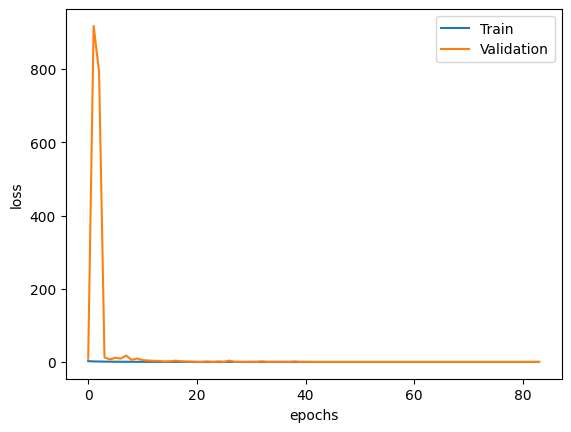

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['Train','Validation'])
plt.show()

In [25]:
model.evaluate(train_images, train_targets)

149/149 ━━━━━━━━━━━━━━━━━━━━ 13s 90ms/step - bbox_loss: 0.0096 - bbox_mae: 0.0775 - class_accuracy: 0.9972 - class_loss: 0.0048 - loss: 0.0144


[0.010058795101940632,
 0.0030704536475241184,
 0.00692761642858386,
 0.062088023871183395,
 0.9981000423431396]

In [22]:
model.evaluate(test_images, test_targets)

16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 313ms/step - bbox_loss: 0.0099 - bbox_mae: 0.0796 - class_accuracy: 0.9752 - class_loss: 0.0642 - loss: 0.0742


[0.06257104873657227,
 0.05458832159638405,
 0.007641819771379232,
 0.06629510223865509,
 0.9783890247344971]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Real is Meningioma
predicted is Meningioma


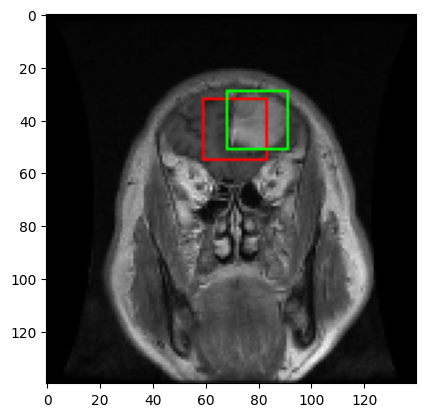

In [28]:
i = 200
img = test_images[i]
cl, bb = model.predict(np.expand_dims(img, axis=0))
real_class = class_names[test_tumor_classes[i][0].astype('uint16')]
print(f'Real is {real_class}')
print('predicted is', end=' ')
show(img*255, class_names[np.argmax(cl)], bb[0]*image_size, test_bboxs[i]*image_size)

In [29]:
model.save('tumorDetector.keras')